In [ ]:
%matplotlib inline

In [ ]:

# Faces recognition example using eigenfaces and SVMs


The dataset used in this example is a preprocessed excerpt of the
"Labeled Faces in the Wild", aka LFW_:

  http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz (233MB)


Expected results for the top 5 most represented people in the dataset:

================== ============ ======= ========== =======
                   precision    recall  f1-score   support
================== ============ ======= ========== =======
     Ariel Sharon       0.67      0.92      0.77        13
     Colin Powell       0.75      0.78      0.76        60
  Donald Rumsfeld       0.78      0.67      0.72        27
    George W Bush       0.86      0.86      0.86       146
Gerhard Schroeder       0.76      0.76      0.76        25
      Hugo Chavez       0.67      0.67      0.67        15
       Tony Blair       0.81      0.69      0.75        36

      avg / total       0.80      0.80      0.80       322
================== ============ ======= ========== =======




In [1]:
from time import time
import logging
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC


print(__doc__)

Automatically created module for IPython interactive environment


In [2]:
# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')

In [3]:
# #############################################################################
# Download the data, if not already on disk and load it as numpy arrays
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

2019-10-19 11:25:53,258 Downloading LFW metadata: https://ndownloader.figshare.com/files/5976012
2019-10-19 11:25:54,901 Downloading LFW metadata: https://ndownloader.figshare.com/files/5976009
2019-10-19 11:25:56,338 Downloading LFW metadata: https://ndownloader.figshare.com/files/5976006
2019-10-19 11:25:58,027 Downloading LFW data (~200MB): https://ndownloader.figshare.com/files/5976015


In [4]:
# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

In [5]:
n_samples

1288

In [6]:
h

50

In [7]:
w

37

In [8]:
lfw_people.images.shape

(1288, 50, 37)

In [9]:
# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data

In [10]:
X

array([[254.      , 254.      , 251.66667 , ...,  87.333336,  88.666664,
         86.666664],
       [ 39.666668,  50.333332,  47.      , ..., 117.666664, 115.      ,
        133.66667 ],
       [ 89.333336, 104.      , 126.      , ..., 175.33333 , 183.33333 ,
        183.      ],
       ...,
       [ 86.      ,  80.333336,  74.666664, ...,  44.      ,  49.666668,
         44.666668],
       [ 50.333332,  65.666664,  88.      , ..., 197.      , 179.33333 ,
        166.33333 ],
       [ 30.      ,  27.      ,  32.666668, ...,  35.      ,  35.333332,
         61.      ]], dtype=float32)

In [11]:

n_features = X.shape[1]

In [12]:
n_features

1850

In [13]:
y = lfw_people.target

In [14]:
y

array([5, 6, 3, ..., 5, 3, 5], dtype=int64)

In [15]:
# the label to predict is the id of the person

target_names = lfw_people.target_names

In [16]:
target_names

array(['Ariel Sharon', 'Colin Powell', 'Donald Rumsfeld', 'George W Bush',
       'Gerhard Schroeder', 'Hugo Chavez', 'Tony Blair'], dtype='<U17')

In [17]:
n_classes = target_names.shape[0]

In [18]:
n_classes

7

In [19]:
print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


In [20]:
# #############################################################################
# Split into a training set and a test set using a stratified k fold

# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

In [23]:
X_train.shape

(966, 1850)

In [24]:
X_test.shape

(322, 1850)

In [25]:
y_train.shape

(966,)

In [26]:
y_test.shape

(322,)

In [27]:
X.shape

(1288, 1850)

In [28]:
y.shape

(1288,)

In [29]:
1288*0.25

322.0

In [30]:
# #############################################################################
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 150

In [31]:
print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, X_train.shape[0]))
t0 = time()

Extracting the top 150 eigenfaces from 966 faces


In [32]:
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

done in 6.864s


In [34]:
eigenfaces = pca.components_.reshape((n_components, h, w))

In [35]:
eigenfaces

array([[[-6.8521299e-03, -7.5269938e-03, -9.1891000e-03, ...,
         -9.9253338e-03, -9.2412503e-03, -9.5519498e-03],
        [-7.2693448e-03, -8.4151486e-03, -1.0821565e-02, ...,
         -1.0395840e-02, -9.4533348e-03, -1.0037365e-02],
        [-8.2803052e-03, -9.9970549e-03, -1.2791980e-02, ...,
         -1.1476460e-02, -9.9721039e-03, -1.0271492e-02],
        ...,
        [-3.5781355e-03, -3.6091944e-03, -6.0094199e-03, ...,
         -1.6046429e-02, -1.4477260e-02, -1.3490868e-02],
        [-5.2311500e-03, -5.1138499e-03, -6.1579905e-03, ...,
         -1.5562141e-02, -1.3553130e-02, -1.2519458e-02],
        [-6.1634039e-03, -6.2009669e-03, -6.6663106e-03, ...,
         -1.4337820e-02, -1.2941872e-02, -1.1882893e-02]],

       [[ 2.3040870e-02,  2.1551995e-02,  2.2753904e-02, ...,
         -2.1021992e-02, -2.1640323e-02, -2.1283392e-02],
        [ 2.2700367e-02,  2.1977261e-02,  2.4531063e-02, ...,
         -2.1732090e-02, -2.2277270e-02, -2.1863475e-02],
        [ 2.2965927e-02, 

In [40]:
print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()

Projecting the input data on the eigenfaces orthonormal basis


In [41]:
X_train_pca = pca.transform(X_train)


In [42]:
X_train_pca

array([[-2.0756025 , -1.0457927 ,  2.1269352 , ..., -1.0985746 ,
        -2.0817478 ,  0.28661504],
       [ 1.3211095 ,  0.59283686,  0.53415436, ..., -0.77941155,
        -0.6268091 , -0.60875624],
       [-0.76119196, -0.0197303 , -0.23990764, ...,  0.7010521 ,
         0.09456967, -0.5619455 ],
       ...,
       [-0.76031333,  0.0402589 , -0.2124515 , ...,  0.19230193,
        -2.7102108 ,  0.02099916],
       [-0.26742113,  0.8386407 , -0.22219595, ..., -0.6394804 ,
        -0.26766545,  0.5674635 ],
       [-1.3195626 , -1.1266966 ,  0.15616919, ..., -1.8965977 ,
        -0.9815868 , -0.4868955 ]], dtype=float32)

In [43]:
X_test_pca = pca.transform(X_test)

In [44]:
X_test_pca

array([[-1.3752165 , -1.8456278 , -0.9252762 , ...,  1.5178872 ,
        -0.22251295,  2.2106576 ],
       [-0.81880206,  1.5192864 , -0.6828062 , ..., -0.92216915,
         0.45399484,  1.0733985 ],
       [-0.86984307, -0.2929443 , -1.2279288 , ..., -0.5876345 ,
        -1.6481102 , -0.36955088],
       ...,
       [ 0.15374437, -0.7177833 ,  0.83880913, ...,  0.9558959 ,
        -0.50038457,  1.0214189 ],
       [ 0.05700841,  0.48382697, -0.15327951, ...,  3.0970838 ,
        -0.4114931 ,  1.4785695 ],
       [ 0.19353302,  0.64531595,  0.74912775, ..., -0.36395884,
         0.8871828 ,  0.85113317]], dtype=float32)

In [45]:
print("done in %0.3fs" % (time() - t0))

done in 48.899s


In [46]:
# #############################################################################
# Train a SVM classification model

print("Fitting the classifier to the training set")
t0 = time()

Fitting the classifier to the training set


In [47]:
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'),
                   param_grid, cv=5, iid=False)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

done in 40.940s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.005, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


In [48]:
param_grid

{'C': [1000.0, 5000.0, 10000.0, 50000.0, 100000.0],
 'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]}

In [49]:
clf

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight='balanced',
                           coef0=0.0, decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid=False, n_jobs=None,
             param_grid={'C': [1000.0, 5000.0, 10000.0, 50000.0, 100000.0],
                         'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [50]:
# #############################################################################
# Quantitative evaluation of the model quality on the test set

print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

Predicting people's names on the test set
done in 0.047s
                   precision    recall  f1-score   support

     Ariel Sharon       0.75      0.46      0.57        13
     Colin Powell       0.80      0.87      0.83        60
  Donald Rumsfeld       0.94      0.63      0.76        27
    George W Bush       0.82      0.98      0.89       146
Gerhard Schroeder       1.00      0.80      0.89        25
      Hugo Chavez       1.00      0.53      0.70        15
       Tony Blair       0.97      0.78      0.86        36

         accuracy                           0.85       322
        macro avg       0.90      0.72      0.79       322
     weighted avg       0.86      0.85      0.84       322

[[  6   2   0   5   0   0   0]
 [  2  52   0   6   0   0   0]
 [  0   2  17   8   0   0   0]
 [  0   3   0 143   0   0   0]
 [  0   1   0   3  20   0   1]
 [  0   4   0   3   0   8   0]
 [  0   1   1   6   0   0  28]]


In [51]:
# #############################################################################
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

In [52]:
# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

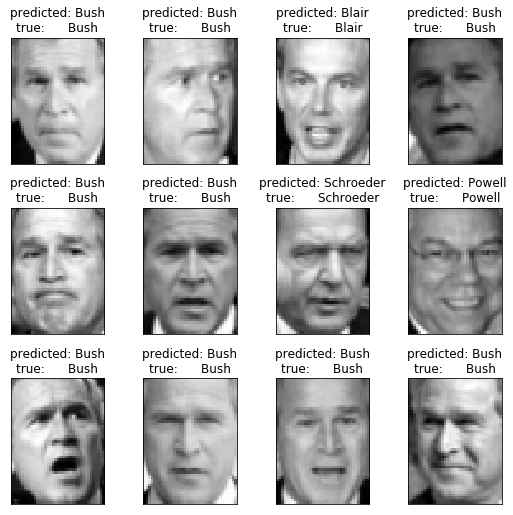

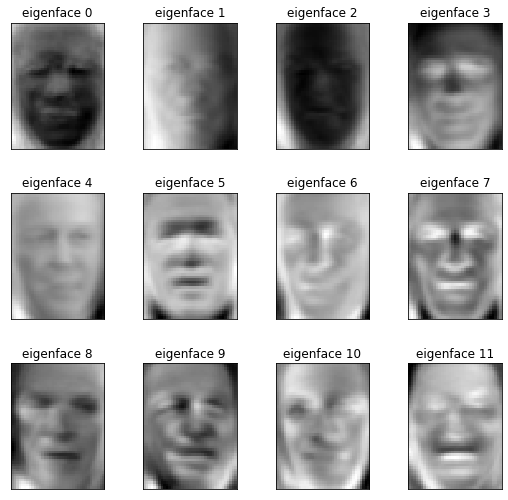

In [53]:
prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()